In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## EDA and Data Loading

In [2]:
cancer_data = load_breast_cancer()
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target, name='diagnosis')

target_names = cancer_data.target_names
print(f"Target names: {target_names}")
print(f"Target Values: {y.unique()}")

# combining for EDA
df = pd.concat([X, y], axis=1)

Target names: ['malignant' 'benign']
Target Values: [0 1]


In [3]:
#observing head
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
# checking for missing values, shape and data types
print("---DataFrame Shape---", df.shape)
print("\n---Data Types---\n", df.dtypes)
print("\n---Missing Values---\n", df.isnull().sum())

---DataFrame Shape--- (569, 31)

---Data Types---
 mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
wors

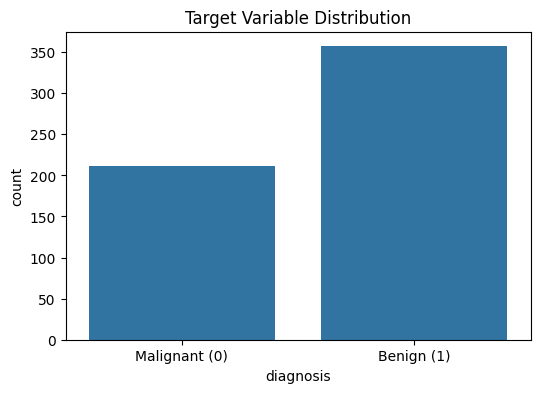

diagnosis
1    0.627417
0    0.372583
Name: proportion, dtype: float64


In [5]:
# checking if the classes are balanced
plt.figure(figsize=(6, 4))
sns.countplot(x=y.map({0: 'Malignant (0)', 1: 'Benign (1)'}))
plt.title('Target Variable Distribution')
plt.show()

print(y.value_counts(normalize=True))

We can see that the classes are relatively balanced (63% benign, and 37% malignant)

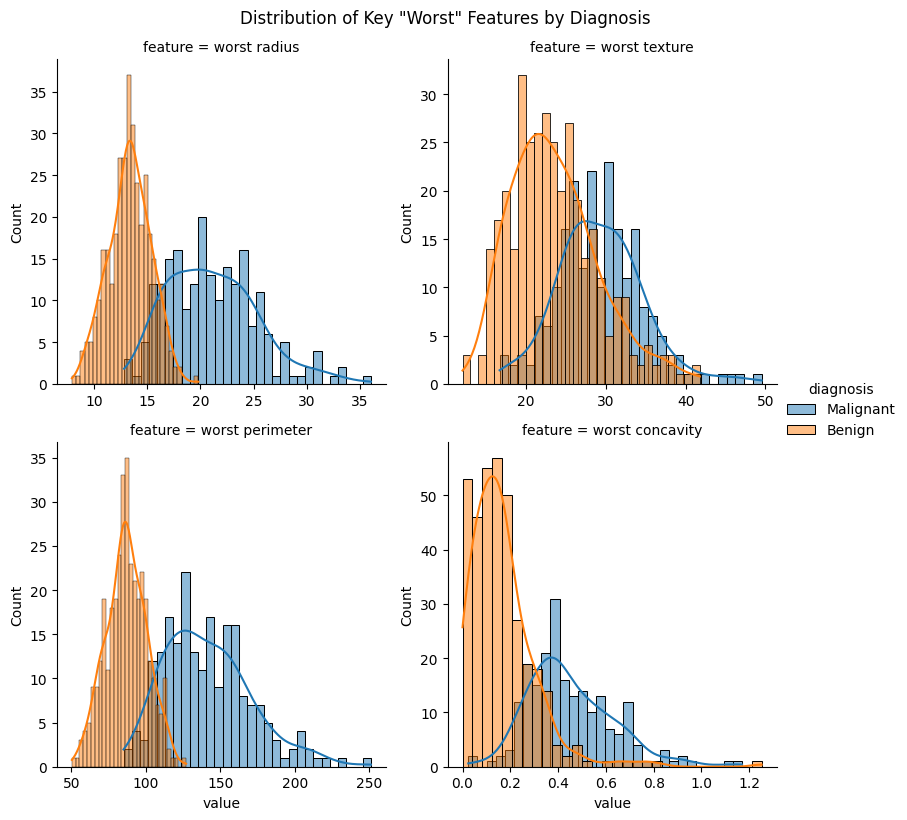

In [6]:
# plotting the distribution of a few key features
features_to_plot = ['worst radius', 'worst texture', 'worst perimeter', 'worst concavity']
df_plot = df.melt(id_vars='diagnosis', value_vars=features_to_plot, var_name='feature')
df_plot['diagnosis'] = df_plot['diagnosis'].map({0: 'Malignant', 1: 'Benign'})

g = sns.FacetGrid(df_plot, col='feature', hue='diagnosis', col_wrap=2, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'value', kde=True, bins=30)
g.add_legend()
plt.suptitle('Distribution of Key "Worst" Features by Diagnosis', y=1.02)
plt.show()

As we can see from the visual above, there is a significant separation between malignant and benign diagnostics for worst concavity, worst perimeter, worst texture, and worst radius.
With this, we can be lead to believe that the features are highly predictive.
Given this differentiation, we might be able to expect models like SVM and Logistic Regression to perform well.

## Data Preprocessing

We'll create a `Pipeline` that first scales the data using `StandardScaler` and then runs the model.

From there, we will create pipelines for our models, build, train, and get baseline results.



In [7]:
# we are doing a 70/30 split of the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (398, 30)
X_test shape: (171, 30)
y_train shape: (398,)
y_test shape: (171,)


In [8]:
scaler = StandardScaler()
scaler

,copy,True
,with_mean,True
,with_std,True


## Model Implementation

### Logistic Regression

Creating a pipeling for logistic regression, train the model and evaluate

In [9]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, solver= 'liblinear'))
])

# training
lr_pipeline.fit(X_train, y_train)

# get predictions on the test set
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# calculating metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print("--- Logistic Regression Test Results ---")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"AUC: {auc_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=target_names))


--- Logistic Regression Test Results ---
Accuracy: 0.9883
AUC: 0.9981

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        64
      benign       0.99      0.99      0.99       107

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



The baseline Logistic Regression model is already very strong, with ~97.7% accuracy. The AUC is exceptionally high at 0.997, indicating excellent separability. The report shows high precision and recall for both classes.

### SVM

We will create a pipeline for linear SVM, train, and evaluate the model

In [10]:
svm_linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # using a new instance of scaler
    ('svm_linear', SVC(kernel='linear', probability=True, random_state=42))
])

# training the model
svm_linear_pipeline.fit(X_train, y_train)

# evaluating the linear svm and checking performance agains the logisitic regression model
y_pred_svm_linear = svm_linear_pipeline.predict(X_test)
y_proba_svm_linear = svm_linear_pipeline.predict_proba(X_test)[:, 1]

# calculating metrics
accuracy_svm_linear = accuracy_score(y_test, y_pred_svm_linear)
auc_svm_linear = roc_auc_score(y_test, y_proba_svm_linear)

print("--- Linear SVM Test Results ---")
print(f"Accuracy: {accuracy_svm_linear:.4f}")
print(f"AUC: {auc_svm_linear:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_linear, target_names=target_names))


--- Linear SVM Test Results ---
Accuracy: 0.9825
AUC: 0.9947

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.97      0.98        64
      benign       0.98      0.99      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



### Non-Linear Kernel (RBF)
Implementing a Non-linear kernel (RBF) and using GridSearchCV to find the best ```C``` and ```gamma``` parameters.

In [11]:
# creating a pipeline for RBF SVM
svm_rbf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # using a new instance of scaler
    ('svm_rbf', SVC(kernel='rbf', probability=True, random_state=42))
])

# defining parameter grid for GridSearchCV
param_grid = {
    'svm_rbf__C': [0.1, 1, 10, 100],
    'svm_rbf__gamma': [1, 0.1, 0.01, 0.001]
}

# setting up GridSearchCV to find the best parameters using 5-fold cross-validation
svm_grid = GridSearchCV(svm_rbf_pipeline, param_grid, refit=True, verbose=2, cv=5, scoring='roc_auc')

# train the model (gridsearchcv will find the best model parameters and retrain it on all training data)
svm_grid.fit(X_train, y_train)
print(f"Best Parameters from GridSearchCV: {svm_grid.best_params_}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...................svm_rbf__C=0.1, svm_rbf__gamma=1; total time=   0.0s
[CV] END ...................svm_rbf__C=0.1, svm_rbf__gamma=1; total time=   0.0s
[CV] END ...................svm_rbf__C=0.1, svm_rbf__gamma=1; total time=   0.0s
[CV] END ...................svm_rbf__C=0.1, svm_rbf__gamma=1; total time=   0.0s
[CV] END ...................svm_rbf__C=0.1, svm_rbf__gamma=1; total time=   0.0s
[CV] END .................svm_rbf__C=0.1, svm_rbf__gamma=0.1; total time=   0.0s
[CV] END .................svm_rbf__C=0.1, svm_rbf__gamma=0.1; total time=   0.0s
[CV] END .................svm_rbf__C=0.1, svm_rbf__gamma=0.1; total time=   0.0s
[CV] END .................svm_rbf__C=0.1, svm_rbf__gamma=0.1; total time=   0.0s
[CV] END .................svm_rbf__C=0.1, svm_rbf__gamma=0.1; total time=   0.0s
[CV] END ................svm_rbf__C=0.1, svm_rbf__gamma=0.01; total time=   0.0s
[CV] END ................svm_rbf__C=0.1, svm_rbf

In [13]:
# Now w will make predictions and evaluate the model
y_pred_svm_rbf = svm_grid.predict(X_test)
y_proba_svm_rbf = svm_grid.predict_proba(X_test)[:, 1]

# calculating metrics
accuracy_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
auc_svm_rbf = roc_auc_score(y_test, y_proba_svm_rbf)

print("--- RBF SVM Test Results ---")
print(f"Accuracy: {accuracy_svm_rbf:.4f}")
print(f"AUC: {auc_svm_rbf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_rbf, target_names=target_names))

--- RBF SVM Test Results ---
Accuracy: 0.9649
AUC: 0.9965

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.92      0.95        64
      benign       0.95      0.99      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



## Model Comparison and Evaluation

In [22]:
def get_metrics(y_true, y_pred, y_proba, target_names):
    '''
    Calculates accuracy, auc, sensitivity, and specificity.
    '''
    # Get values from confusion matrix
    # tn = Actual Benign (1), Predicted Benign (1)
    # fp = Actual Benign (1), Predicted Malignant (0)
    # fn = Actual Malignant (0), Predicted Benign (1)
    # tp = Actual Malignant (0), Predicted Malignant (0)
    
    # getting values from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    # Sensitivity (Recall) = How many Malignant cases did we find? (Higher is better)
    # This directly measures our goal of minimizing False Negatives.
    sensitivity = tp / (tp + fn)  # Malignant Recall

    # Specificity = How many Benign cases did we correctly identify? (Higher is better)
    # This measures how well we avoid False Positives.
    specificity = tn / (tn + fp)  # Benign Recall

    # getting raw counts
    false_negatives = fn
    false_positives = fp

    # report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    # precision_m = report['malignant']['precision']
    # recall_m = report['malignant']['recall']
    # precision_b = report['benign']['precision']
    # recall_b = report['benign']['recall']
    return {
        'Accuracy': accuracy,
        'AUC': auc,
        'Sensitivity (Malignant Recall)': sensitivity,
        'Specificity (Benign Recall)': specificity,
        'False Negatives (FN)': false_negatives,
        'False Positives (FP)': false_positives
    }

In [25]:
# getting metics for all models
metrics_lr = get_metrics(y_test, y_pred_lr, y_proba_lr, target_names)
metrics_svm_linear = get_metrics(y_test, y_pred_svm_linear, y_proba_svm_linear, target_names)
metrics_svm_rbf = get_metrics(y_test, y_pred_svm_rbf, y_proba_svm_rbf, target_names)

# creating a comparison df
comparison_df = pd.DataFrame({
    'Logistic Regression': metrics_lr,
    'SVM Linear': metrics_svm_linear,
    'SVM RBF (Tuned)': metrics_svm_rbf
})

print("--- Model Performance Comparison ---")
comparison_df

--- Model Performance Comparison ---


,Logistic Regression,SVM Linear,SVM RBF (Tuned)
Accuracy,0.988304,0.982456,0.964912
AUC,0.998102,0.994743,0.996495
Sensitivity (Malignant Recall),0.990654,0.990654,0.990654
Specificity (Benign Recall),0.984375,0.968750,0.921875
False Negatives (FN),1.000000,1.000000,1.000000
False Positives (FP),1.000000,2.000000,5.000000


### Observations

For this kind of problem, we decided the best model is the one with the **lowest False Negatives (FN)**. This is the worst-case scenario: the model predicts that a patient is Benign (class 1), but they actually have a Malignant (class 0) tumor. This is the "someone who had cancer and was not treated" situation.

**Key Metrics: Sensitivity (Malignant Recall)**

In our results table, this is tracked by the **"Sensitivity (Malignant Recall)"** column. This metric tells us: "Of all the people who really had cancer (Malignant), what percentage did the model correctly identify?"

- Formula: Sensitivity = True Positives / (True Positives + False Negatives)
- In this case: TP / (TP + FN) where TP = correctly identified malignant cases, FN = missed malignant cases
- **Higher Sensitivity = Fewer False Negatives = Fewer missed cancer cases**

**Result Analysis**

All three models achieved:
- **Sensitivity (Malignant Recall): 0.990654 (~99.07%)**
- **False Negatives (FN): 1**

This means that all three models missed exactly 1 malignant case out of 107 malignant patients in the test set.

**Model Ranking (Based on FN and Overall Performance)**

Since all models have identical False Negatives, we consider secondary metrics:

1. **Logistic Regression** **BEST CHOICE**
   - False Negatives: 1
   - Sensitivity (Malignant Recall): 0.990654
   - **Accuracy: 0.988304** (highest)
   - **False Positives: 1** (lowest, tied with SVM Linear)
   - **Specificity (Benign Recall): 0.984375**
   - **Interpretation**: Misses only 1 cancer case while maintaining the highest overall accuracy and minimal false alarms

2. **SVM (Linear Kernel)**: Tied for Best
   - False Negatives: 1
   - Sensitivity (Malignant Recall): 0.990654
   - Accuracy: 0.982456
   - **False Positives: 2**
   - Specificity (Benign Recall): 0.968750
   - **Interpretation**: Equally good at catching malignant cases but slightly lower accuracy

3. **SVM (RBF Kernel, tuned)**
   - False Negatives: 1
   - Sensitivity (Malignant Recall): 0.990654
   - Accuracy: 0.964912 (lowest)
   - **False Positives: 5** (highest)
   - Specificity (Benign Recall): 0.921875 (lowest)
   - **Interpretation**: Catches the same number of cancer cases but generates more false alarms (tells 5 healthy patients they have cancer)


From this, Logistic Regression is the best model for this problem because it achieves the primary objective: **only 1 False Negative** (minimal missed cancers). It has the highest overall accuracy (98.83%). It has the fewest False Positives (only 1 healthy patient incorrectly flagged). It's simpler and more interpretable than SVM models

All models are excellent at the critical task of not missing cancer cases (99.07% sensitivity), but Logistic Regression provides the best balance of catching cancer while avoiding unnecessary alarm for healthy patients.